# Doppler Ultrasound → Time-Series Extraction

Extract velocity time-series from spectral Doppler ultrasound images.

## What this does
- **Snapshot (DICOM still)**: Extract velocity envelope from a single spectral Doppler image
- **Video (WMV/MP4/multi-frame DICOM)**: Extract velocity envelopes from scrolling spectrogram at time intervals

## How to use
1. Run the **Setup** cell (creates `output/` folder and defines helper functions)
2. Place your files:
   - DICOM snapshots: `DICOM/` folder
   - Videos: `Converted_files/` folder
3. Edit file paths in the processing cells and run them
4. Adjust crop ratios and calibration if your ultrasound machine layout differs

## Outputs
All results saved to `output/`:
- CSV files: `time_s, velocity_cm_s`
- PNG plots: spectrograms + velocity curves

## Export to HTML
```bash
python -m jupyter nbconvert --to html --no-input --output-dir output dicom_to_ts.ipynb
```

In [15]:
# ══════════════════════════════════════════════════════════════════════════════
# SETUP - Run this first
# ══════════════════════════════════════════════════════════════════════════════
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

OUTPUT = Path("output")
OUTPUT.mkdir(exist_ok=True)

# ─── Shared helper functions ───

def to_grayscale(image_array):
    """Convert image to grayscale float32."""
    if image_array.ndim == 3 and image_array.shape[-1] == 3:
        gray = 0.299*image_array[...,0] + 0.587*image_array[...,1] + 0.114*image_array[...,2]
    else:
        gray = image_array.astype(np.float32)
    return gray.astype(np.float32)

def crop_spectrogram_panel(img, x1_ratio=0.04, x2_ratio=0.925, y1_ratio=0.69, y2_ratio=0.85):
    """Crop the spectral Doppler panel using ratios."""
    H, W = img.shape
    x1, x2 = int(W*x1_ratio), int(W*x2_ratio)
    y1, y2 = int(H*y1_ratio), int(H*y2_ratio)
    return img[y1:y2, x1:x2], (x1, x2, y1, y2)

def find_baseline(panel):
    """Detect baseline (horizontal zero-velocity line) in spectral panel."""
    gy = np.abs(np.diff(panel, axis=0))
    row_strength = gy.mean(axis=1)
    Hp = panel.shape[0]
    search_from = Hp // 3
    baseline_idx = search_from + np.argmax(row_strength[search_from:])
    return float(baseline_idx)

def find_calibration_tick(panel, baseline_y, known_px=0, fallback=40.0):
    """Find pixel distance from baseline to first velocity grid line."""
    if known_px > 0:
        return float(known_px)
    gy = np.abs(np.diff(panel, axis=0))
    row_strength = gy.mean(axis=1)
    baseline_idx = int(baseline_y)
    up_band = row_strength[:baseline_idx][::-1]
    if up_band.size > 10:
        return float(np.argmax(up_band[5:]) + 5)
    return fallback

def extract_velocity_envelope(panel, baseline_y, pixels_per_cm_s, time_span_s):
    """Extract velocity time-series from spectral Doppler panel."""
    # Normalize and smooth vertically
    P = (panel - panel.min()) / (np.ptp(panel) + 1e-9)
    P_sm = (np.pad(P, ((1,1),(0,0)), mode='edge')[:-2,:] + P + np.pad(P, ((1,1),(0,0)), mode='edge')[2:,:]) / 3.0
    
    # Find brightest pixel above baseline in each column
    Hp, Wp = P_sm.shape
    yb = int(min(max(round(baseline_y), 1), Hp-1))
    y_env = np.array([np.argmax(P_sm[:yb+1, c]) for c in range(Wp)], dtype=np.float32)
    
    # Convert to velocity
    vel_cm_s = (baseline_y - y_env) / pixels_per_cm_s
    
    # Smooth horizontally
    win = max(3, Wp//200)
    if win % 2 == 0:
        win += 1
    vel_smooth = np.convolve(np.pad(vel_cm_s, win//2, mode='edge'), 
                             np.ones(win)/win, mode='valid')
    
    # Time axis
    time_s = np.linspace(0, time_span_s, len(vel_smooth), endpoint=False)
    
    return time_s, vel_smooth

print(f"✓ Setup complete. Outputs will be saved to: {OUTPUT.resolve()}")


✓ Setup complete. Outputs will be saved to: C:\Users\Henry\Documents\MMS\Nelida\dus_pictures\output


---
## Optional: Quick DICOM Inspection
View a DICOM file to check frame count and appearance.


<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Henry\AppData\Local\Temp\ipykernel_13648\337766493.py:8: SyntaxWarning: invalid escape sequence '\D'
  test_file = Path('..\DICOM\A0023')


Number of frames: 1


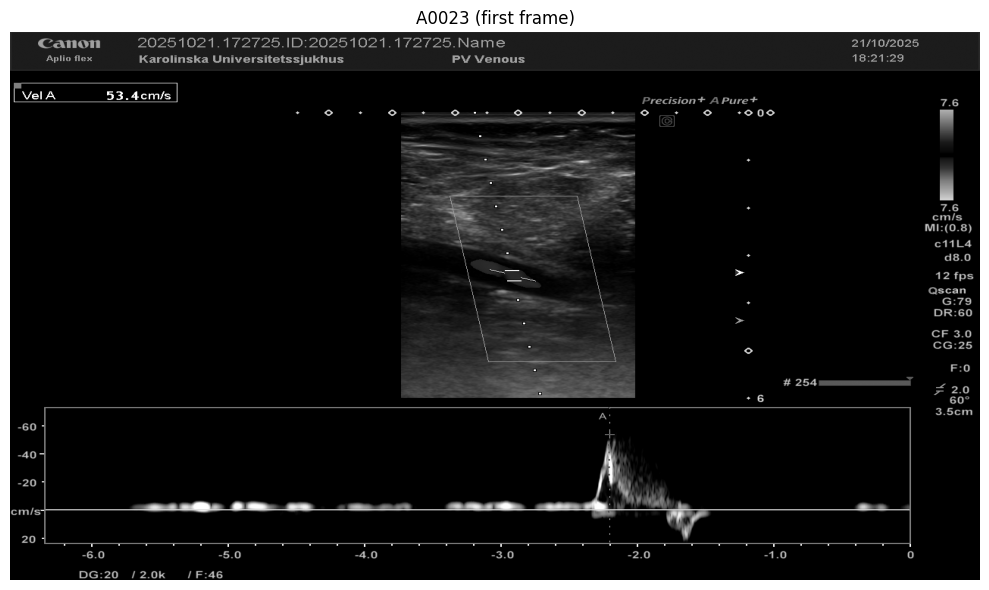

In [16]:
# Quick DICOM inspector: shows frame count and first frame
from pathlib import Path
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# Edit this path to point at a DICOM file (file or folder depending on your data)
test_file = Path('..\DICOM\A0023')

# Read DICOM (pydicom accepts either a path-like or string)
try:
    ds = pydicom.dcmread(str(test_file))
except Exception as e:
    raise RuntimeError(f'Failed to read DICOM {test_file}: {e}')

nframes = int(ds.get('NumberOfFrames', 1))
print(f'Number of frames: {nframes}')

# Access pixel data and pick first frame if multi-frame
img = ds.pixel_array
# pydicom may return (frames, H, W) or (frames, H, W, C) depending on data
if getattr(img, 'ndim', 0) >= 3 and img.shape[0] == nframes:
    first = img[0]
else:
    first = img

# Use the existing to_grayscale helper if available; fall back to simple conversion
try:
    gray = to_grayscale(first)
except NameError:
    if first.ndim == 3 and first.shape[-1] == 3:
        gray = (0.299*first[...,0] + 0.587*first[...,1] + 0.114*first[...,2]).astype(np.float32)
    else:
        gray = first.astype(np.float32)

plt.figure(figsize=(10,6))
plt.imshow(gray, cmap='gray', aspect='auto')
plt.title(f'{test_file.name} (first frame)')
plt.axis('off')
plt.tight_layout()
plt.show()

---
## Process DICOM Snapshot
Extract velocity envelope from a single spectral Doppler image.

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Henry\AppData\Local\Temp\ipykernel_13648\535521747.py:4: SyntaxWarning: invalid escape sequence '\D'
  dcm_path = Path('..\DICOM\A0023')


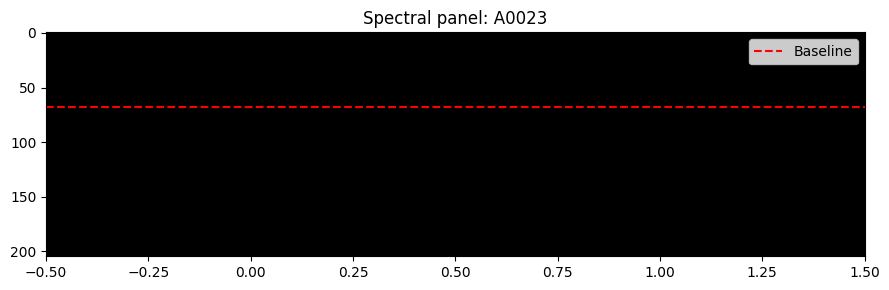

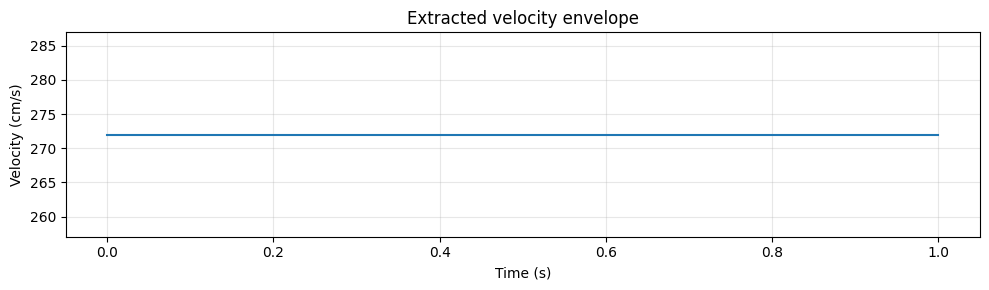

✓ Saved: output\A0023_timeseries.csv
  Crop: x[0:2], y[883:1088]
  Baseline: 68.0 px, Scale: 0.250 px/(cm/s)


In [ ]:
import pydicom
import numpy as np
# ═══ EDIT THESE ═══
dcm_path = Path('..\DICOM\A0023')
CROP_X1, CROP_X2 = 0.04, 0.925  # left/right of spectral box
CROP_Y1, CROP_Y2 = 0.69, 0.85   # top/bottom of spectral box
TIME_SPAN_S = 2.0               # time span shown in spectral box
TICK_VALUE_CM_S = 20.0          # velocity value per grid tick (cm/s)
KNOWN_TICK_PX = 0               # if you know pixel distance to tick, set here; else 0 = auto-detect
# ══════════════════

# Load DICOM and convert to grayscale (handles single- and multi-frame)
try:
    ds = pydicom.dcmread(str(dcm_path))
except Exception as e:
    raise RuntimeError(f'Failed to read DICOM {dcm_path}: {e}')
# Get pixel array and select first frame if necessary
pix = ds.pixel_array
if getattr(pix, 'ndim', 0) >= 3 and pix.shape[0] > 1:
    frame = pix[0]
else:
    frame = pix
# Convert to grayscale using helper if available
try:
    img = to_grayscale(frame)
except NameError:
    if frame.ndim == 3 and frame.shape[-1] == 3:
        img = (0.299*frame[...,0] + 0.587*frame[...,1] + 0.114*frame[...,2]).astype(np.float32)
    else:
        img = frame.astype(np.float32)

# Crop spectral panel
panel, crop_box = crop_spectrogram_panel(img, CROP_X1, CROP_X2, CROP_Y1, CROP_Y2)

# Calibrate
baseline_y = find_baseline(panel)
tick_px = find_calibration_tick(panel, baseline_y, KNOWN_TICK_PX)
px_per_cm_s = tick_px / TICK_VALUE_CM_S

# Extract velocity
time_s, vel_cm_s = extract_velocity_envelope(panel, baseline_y, px_per_cm_s, TIME_SPAN_S)
# Also compute pixel positions for scatter overlay (convert velocity back to pixel y)
Wp = panel.shape[1]
# Interpolate vel_cm_s length to panel width if needed
if len(time_s) != Wp:
    # resample vel to width for pixel mapping
    from scipy.signal import resample
    vel_px = baseline_y - np.interp(np.linspace(0, len(vel_cm_s), Wp, endpoint=False), np.arange(len(vel_cm_s)), vel_cm_s) * px_per_cm_s
else:
    vel_px = baseline_y - vel_cm_s * px_per_cm_s

# Save CSV
csv_name = dcm_path.stem + "_timeseries.csv"
csv_path = OUTPUT / csv_name
np.savetxt(csv_path, np.column_stack([time_s, vel_cm_s]), delimiter=",",
           header="time_s,velocity_cm_s", comments="")

# Save plots
fig1, ax1 = plt.subplots(figsize=(9, 3))
ax1.imshow(panel, cmap='gray', aspect='auto')
ax1.axhline(baseline_y, ls='--', color='red', label='Baseline')
# Overlay extracted envelope as points
xs = np.linspace(0, panel.shape[1]-1, len(vel_px))
ax1.scatter(xs, vel_px, s=6, c='cyan', alpha=0.8, label='Envelope pts')
ax1.set_title(f'Spectral panel: {dcm_path.name}')
ax1.legend()
plt.tight_layout()
fig1.savefig(OUTPUT / (dcm_path.stem + '_panel.png'), dpi=150)
plt.show()

fig2, ax2 = plt.subplots(figsize=(10, 3))
ax2.plot(time_s, vel_cm_s, linewidth=1.0, marker='.', markersize=4, linestyle='-')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Velocity (cm/s)')
ax2.set_title('Extracted velocity envelope')
ax2.grid(alpha=0.3)
plt.tight_layout()
fig2.savefig(OUTPUT / (dcm_path.stem + '_velocity.png'), dpi=150)
plt.show()

print(f"✓ Saved: {csv_path}")
print(f"  Crop: x[{crop_box[0]}:{crop_box[1]}], y[{crop_box[2]}:{crop_box[3]}]")
print(f"  Baseline: {baseline_y:.1f} px, Scale: {px_per_cm_s:.3f} px/(cm/s)")

---
## Process Video (Multi-frame)
Extract velocity envelopes from a scrolling spectrogram video at fixed time intervals.

In [4]:
import math

# ═══ EDIT THESE ═══
VIDEO_PATH = Path("./Converted_files/Vein/Vein_cont.wmv")
CROP_X1, CROP_X2 = 0.04, 0.925
CROP_Y1, CROP_Y2 = 0.69, 0.85
TIME_SPAN_S = 6.0       # time span shown in each spectral panel
TICK_VALUE_CM_S = 20.0
KNOWN_TICK_PX = 0
WINDOW_INTERVAL_S = 6.38  # extract one envelope every N seconds
# ══════════════════

# Load video frames
IS_DICOM = VIDEO_PATH.suffix.lower() in (".dcm", ".dicom")

if IS_DICOM:
    import pydicom
    ds = pydicom.dcmread(str(VIDEO_PATH), stop_before_pixels=False)
    nframes = int(ds.get("NumberOfFrames", 1))
    if nframes <= 1:
        raise ValueError("DICOM has only 1 frame. Use the snapshot cell instead.")
    frames = ds.pixel_array
    ft_ms = float(ds.get("FrameTime", 0))
    FPS = (1000.0 / ft_ms) if ft_ms > 0 else 30.0
else:
    try:
        import cv2
        cap = cv2.VideoCapture(str(VIDEO_PATH))
        if not cap.isOpened():
            raise RuntimeError("Cannot open video")
        FPS = cap.get(cv2.CAP_PROP_FPS) or 30.0
        frames = []
        while True:
            ok, frame = cap.read()
            if not ok:
                break
            frames.append(frame[..., ::-1])  # BGR→RGB
        cap.release()
        frames = np.array(frames)
    except Exception:
        import imageio
        reader = imageio.get_reader(str(VIDEO_PATH))
        FPS = reader.get_meta_data().get("fps", 30.0)
        frames = np.array([f for f in reader])
        reader.close()

n_frames = len(frames)
video_duration_s = n_frames / FPS
n_windows = int(video_duration_s / WINDOW_INTERVAL_S)

print(f"Video: {n_frames} frames @ {FPS:.1f} fps = {video_duration_s:.1f}s")
print(f"Will extract {n_windows} windows at {WINDOW_INTERVAL_S}s intervals\n")

# Calibrate from first frame
first_gray = to_grayscale(frames[0])
panel0, _ = crop_spectrogram_panel(first_gray, CROP_X1, CROP_X2, CROP_Y1, CROP_Y2)
baseline_y = find_baseline(panel0)
tick_px = find_calibration_tick(panel0, baseline_y, KNOWN_TICK_PX)
px_per_cm_s = tick_px / TICK_VALUE_CM_S

out_base = VIDEO_PATH.stem

for i in range(n_windows):
    t_sec = (i + 1) * WINDOW_INTERVAL_S
    frame_idx = int(t_sec * FPS) - 1
    frame_idx = max(0, min(frame_idx, n_frames - 1))
    
    # Extract panel
    gray = to_grayscale(frames[frame_idx])
    panel, _ = crop_spectrogram_panel(gray, CROP_X1, CROP_X2, CROP_Y1, CROP_Y2)
    
    # Extract velocity
    time_s, vel_cm_s = extract_velocity_envelope(panel, baseline_y, px_per_cm_s, TIME_SPAN_S)
    
    # Save CSV
    csv_name = f"{out_base}_w{i+1}_timeseries.csv"
    csv_path = OUTPUT / csv_name
    np.savetxt(csv_path, np.column_stack([time_s, vel_cm_s]), delimiter=",",
               header="time_s,velocity_cm_s", comments="")
    
    # Save plots
    fig1, ax1 = plt.subplots(figsize=(10, 3))
    ax1.imshow(panel, cmap='gray', aspect='auto')
    ax1.axhline(baseline_y, ls='--', color='red')
    ax1.set_title(f"Window {i+1} @ {t_sec:.1f}s")
    plt.tight_layout()
    fig1.savefig(OUTPUT / f"{out_base}_w{i+1}_panel.png", dpi=150)
    plt.close(fig1)
    
    fig2, ax2 = plt.subplots(figsize=(10, 3))
    ax2.plot(time_s, vel_cm_s, linewidth=1.5)
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Velocity (cm/s)")
    ax2.set_title(f"Window {i+1} velocity envelope")
    ax2.grid(alpha=0.3)
    plt.tight_layout()
    fig2.savefig(OUTPUT / f"{out_base}_w{i+1}_velocity.png", dpi=150)
    plt.close(fig2)
    
    print(f"✓ Window {i+1}: {csv_name}")

print(f"\n✓ Done! All outputs in {OUTPUT.resolve()}")


FileNotFoundError: No such file: 'c:\Users\Henry\Documents\MMS\Nelida\dus_pictures\Converted_files\Vein\Vein_cont.wmv'